# Load and Inspect Log Data

In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install json

import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

  Using cached pillow-11.3.0-cp313-cp313-macosx_10_13_x86_64.whl.metadata (9.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 3.0 MB/s  0:00:02m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.4 MB/s  0:00:00 eta 0:00:01
Using cached pillow-11.3.0-cp313-cp313-macosx_10_13_x86_64.whl (5.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Load your log data
def load_logs(log_file):
    records = []
    with open(log_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            try:
                records.append(json.loads(line))
            except Exception as e:
                print(f"Skipping invalid line {line_num}: {e}")
    return pd.DataFrame(records)

# Load your data
df = load_logs('logs/ml_training_data.jsonl')

# Basic information
print("=== BASIC DATA INFO ===")
print(f"Total log entries: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(f"Column names: {list(df.columns)}")
print("\nData types:")
print(df.dtypes)


=== BASIC DATA INFO ===
Total log entries: 134682
Number of columns: 27
Column names: ['event_type', 'timestamp', 'duration_hours', 'request_id', 'client_ip', 'method', 'path', 'query_string', 'user_agent', 'protocol', 'content_length', 'connection_header', 'headers', 'concurrent_requests', 'client_request_count', 'status_code', 'response_time_ms', 'response_size', 'content_type', 'server_metrics', 'endpoint', 'attack_name', 'config', 'total_requests', 'duration_seconds', 'error_message', 'error_type']

Data types:
event_type               object
timestamp                object
duration_hours          float64
request_id               object
client_ip                object
method                   object
path                     object
query_string             object
user_agent               object
protocol                 object
content_length          float64
connection_header        object
headers                  object
concurrent_requests     float64
client_request_count    float64

# Check Data Completeness

In [4]:
# Check for missing values
print("\n=== MISSING VALUES CHECK ===")
missing_data = df.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

# Check data coverage
print(f"\nData completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.2f}%")



=== MISSING VALUES CHECK ===
Missing values per column:
duration_hours          134680
request_id                  18
client_ip                75492
method                   75492
path                     75491
query_string             75492
user_agent               59208
protocol                 75492
content_length           75492
connection_header        75492
headers                  75492
concurrent_requests      75492
client_request_count     75492
status_code              59209
response_time_ms         59209
response_size            75493
content_type             75493
server_metrics           75493
endpoint                118398
attack_name             134666
config                  134674
total_requests          134674
duration_seconds        134674
error_message           134681
error_type              134681
dtype: int64

Data completeness: 38.95%


# Analyze Time Range and Event Types

In [5]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("\n=== TIME RANGE ANALYSIS ===")
print(f"Start time: {df['timestamp'].min()}")
print(f"End time: {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

# Analyze event types
print("\n=== EVENT TYPE DISTRIBUTION ===")
if 'event_type' in df.columns:
    event_counts = df['event_type'].value_counts()
    print(event_counts)
    print(f"\nEvent type percentages:")
    print((event_counts / len(df) * 100).round(2))
else:
    print("No 'event_type' column found")



=== TIME RANGE ANALYSIS ===
Start time: 2025-08-20 12:33:38.111911
End time: 2025-08-22 13:48:04.104510
Duration: 2 days 01:14:25.992599

=== EVENT TYPE DISTRIBUTION ===
event_type
request_start           59190
request_end             59189
normal_request          16284
attack_end                  8
attack_start                8
normal_traffic_start        2
error                       1
Name: count, dtype: int64

Event type percentages:
event_type
request_start           43.95
request_end             43.95
normal_request          12.09
attack_end               0.01
attack_start             0.01
normal_traffic_start     0.00
error                    0.00
Name: count, dtype: float64


# Validate Normal vs Attack Data Distribution

In [6]:
print("\n=== NORMAL VS ATTACK DATA VALIDATION ===")

# Count normal requests vs attacks
normal_requests = len(df[df['event_type'].isin(['request_start', 'request_end', 'normal_request'])])
attack_events = len(df[df['event_type'].str.contains('attack', na=False)])

print(f"Normal traffic events: {normal_requests:,}")
print(f"Attack-related events: {attack_events:,}")
print(f"Normal to Attack ratio: {normal_requests/max(attack_events, 1):.2f}:1")

# Check if all 4 attack intensities are present
if 'attack_name' in df.columns:
    attack_types = df[df['event_type'] == 'attack_start']['attack_name'].value_counts()
    print(f"\nAttack intensity distribution:")
    print(attack_types)



=== NORMAL VS ATTACK DATA VALIDATION ===
Normal traffic events: 134,663
Attack-related events: 16
Normal to Attack ratio: 8416.44:1

Attack intensity distribution:
attack_name
Light Rapid Reset      2
Medium Rapid Reset     2
Heavy Rapid Reset      2
Extreme Rapid Reset    2
Name: count, dtype: int64


# Data Quality Issues Detection

In [7]:
print("\n=== DATA QUALITY ISSUES ===")

# Check for duplicate timestamps
duplicate_timestamps = df['timestamp'].duplicated().sum()
print(f"Duplicate timestamps: {duplicate_timestamps}")

# Check for impossible values
if 'response_time_ms' in df.columns:
    negative_response_times = (df['response_time_ms'] < 0).sum()
    very_high_response_times = (df['response_time_ms'] > 10000).sum()  # >10 seconds
    print(f"Negative response times: {negative_response_times}")
    print(f"Very high response times (>10s): {very_high_response_times}")

# Check for suspicious patterns
if 'client_ip' in df.columns:
    unique_ips = df['client_ip'].nunique()
    print(f"Unique client IPs: {unique_ips}")
    
    # Top IPs by request count
    top_ips = df['client_ip'].value_counts().head(5)
    print(f"Top 5 most active IPs:")
    print(top_ips)



=== DATA QUALITY ISSUES ===
Duplicate timestamps: 0
Negative response times: 0
Very high response times (>10s): 0
Unique client IPs: 1
Top 5 most active IPs:
client_ip
127.0.0.1    59190
Name: count, dtype: int64


# Time Gap Analysis

In [9]:
print("\n=== TIME GAP ANALYSIS ===")

# Sort by timestamp
df_sorted = df.sort_values('timestamp')

# Calculate time gaps between events
df_sorted['time_gap'] = df_sorted['timestamp'].diff()

# Find large gaps (potential data loss)
large_gaps = df_sorted[df_sorted['time_gap'] > pd.Timedelta(minutes=5)]
print(f"Large gaps (>5 minutes): {len(large_gaps)}")

if len(large_gaps) > 0:
    print("Large gaps found:")
    for idx, gap in large_gaps.iterrows():
        print(f"  Gap of {gap['time_gap']} at {gap['timestamp']}")



=== TIME GAP ANALYSIS ===
Large gaps (>5 minutes): 2
Large gaps found:
  Gap of 1 days 01:53:01.087109 at 2025-08-21 14:45:22.893021
  Gap of 0 days 00:37:36.281687 at 2025-08-21 15:53:29.017358


# Save Data Quality Report

In [10]:
# Create comprehensive data quality report
def create_data_quality_report(df):
    report = {
        'assessment_timestamp': datetime.now().isoformat(),
        'total_records': len(df),
        'time_range': {
            'start': str(df['timestamp'].min()),
            'end': str(df['timestamp'].max()),
            'duration_hours': (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600
        },
        'data_completeness': {
            'total_missing_values': int(df.isnull().sum().sum()),
            'completeness_percentage': round((1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100, 2)
        },
        'event_distribution': df['event_type'].value_counts().to_dict() if 'event_type' in df.columns else {},
        'data_quality_issues': {
            'duplicate_timestamps': int(df['timestamp'].duplicated().sum()),
            'large_time_gaps': len(df_sorted[df_sorted['time_gap'] > pd.Timedelta(minutes=5)]) if 'time_gap' in df_sorted.columns else 0
        }
    }
    return report

# Generate and save report
quality_report = create_data_quality_report(df)

with open('logs/data_quality_report.json', 'w') as f:
    json.dump(quality_report, f, indent=2)

print("\n=== DATA QUALITY SUMMARY ===")
print(f"✅ Total records: {quality_report['total_records']:,}")
print(f"✅ Duration: {quality_report['time_range']['duration_hours']:.2f} hours")
print(f"✅ Data completeness: {quality_report['data_completeness']['completeness_percentage']}%")
print(f"✅ Report saved to: logs/data_quality_report.json")



=== DATA QUALITY SUMMARY ===
✅ Total records: 134,682
✅ Duration: 49.24 hours
✅ Data completeness: 38.95%
✅ Report saved to: logs/data_quality_report.json


# Basic Visualization

/var/folders/y2/vgvvjpr93c9294ggnp_qfrbc0000gn/T/ipykernel_53036/1087257513.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('timestamp').resample('1H').size().plot()


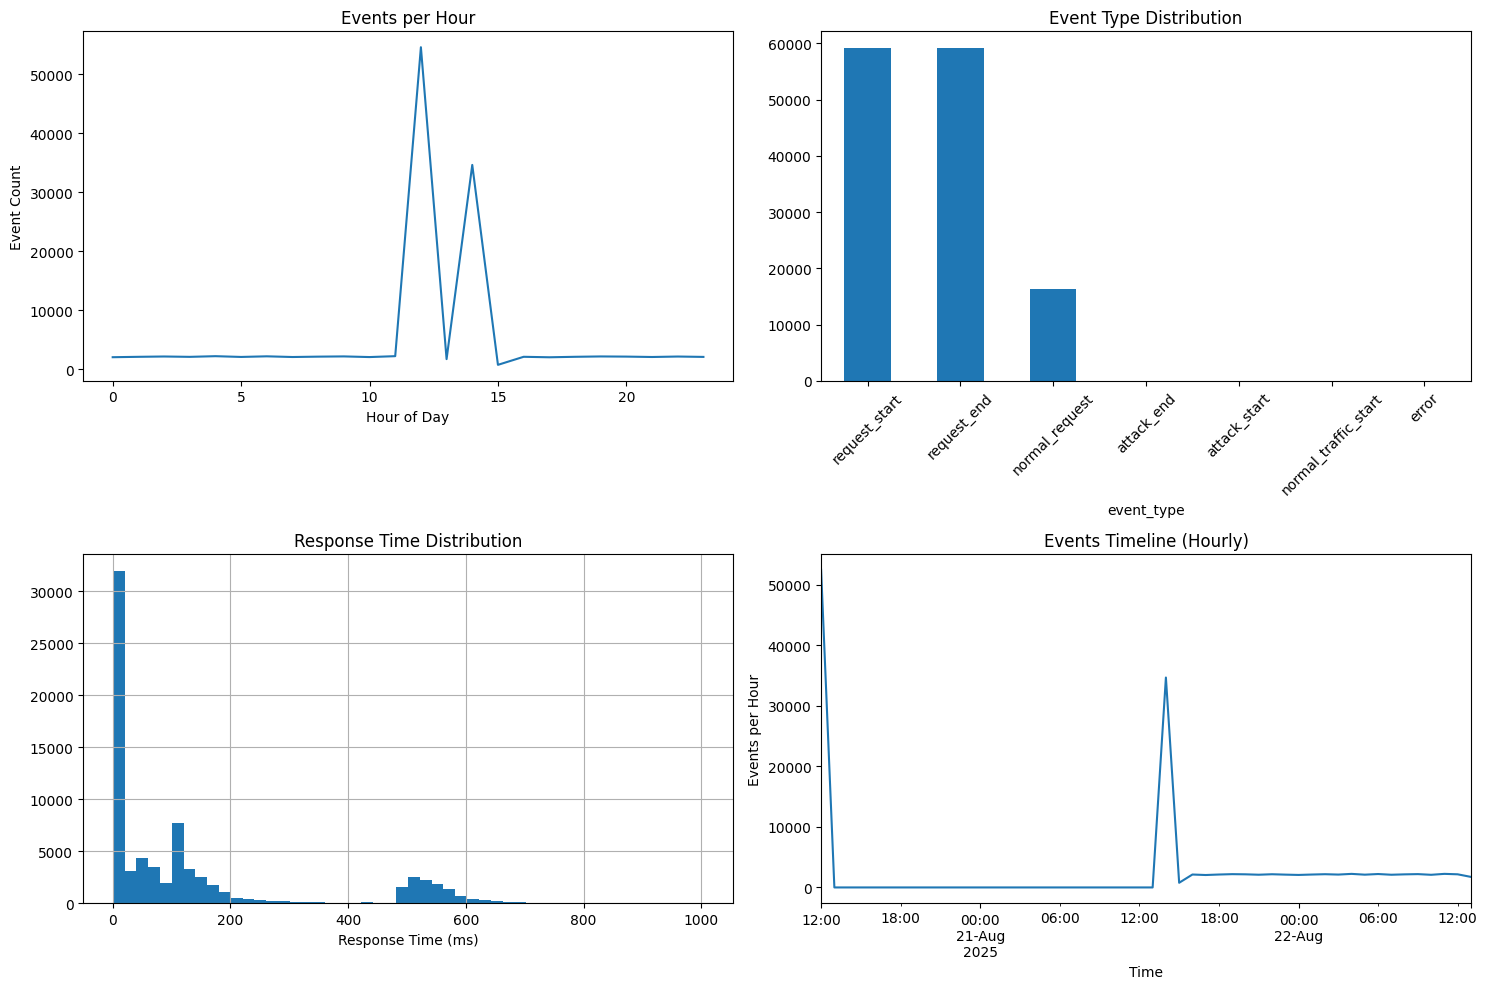

✅ Visualization saved to: logs/data_quality_overview.png


In [11]:
# Create basic visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Events over time
plt.subplot(2, 2, 1)
df['hour'] = df['timestamp'].dt.hour
hourly_counts = df.groupby('hour').size()
plt.plot(hourly_counts.index, hourly_counts.values)
plt.title('Events per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')

# Plot 2: Event type distribution
plt.subplot(2, 2, 2)
if 'event_type' in df.columns:
    df['event_type'].value_counts().plot(kind='bar', rot=45)
    plt.title('Event Type Distribution')

# Plot 3: Response time distribution (if available)
plt.subplot(2, 2, 3)
if 'response_time_ms' in df.columns:
    df['response_time_ms'].hist(bins=50)
    plt.title('Response Time Distribution')
    plt.xlabel('Response Time (ms)')

# Plot 4: Events timeline
plt.subplot(2, 2, 4)
df.set_index('timestamp').resample('1H').size().plot()
plt.title('Events Timeline (Hourly)')
plt.xlabel('Time')
plt.ylabel('Events per Hour')

plt.tight_layout()
plt.savefig('logs/data_quality_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: logs/data_quality_overview.png")
